In [133]:
# 引入库
from jqdata import *

import pickle
import itertools  # 迭代器工具
import numpy as np
import pandas as pd
import prettytable as pt
import scipy.stats as st
import statsmodels.api as sm
# granger 因果检验
from statsmodels.tsa.stattools import grangercausalitytests


import calendar  # 日历
import datetime as dt
from tqdm import *
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from IPython.core.display import HTML

# 画图
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as mg # 不规则子图
import matplotlib.dates as mdate
import seaborn as sns

# 设置字体 用来正常显示中文标签
mpl.rcParams['font.sans-serif'] = ['SimHei']
#mpl.rcParams['font.family'] = 'serif'
# 用来正常显示负号
mpl.rcParams['axes.unicode_minus'] = False
# 图表主题
plt.style.use('seaborn')

# 波动率与趋势

波动率是用来反映市场波动幅度的大小，大家通常也用来观察市场情绪或预 测市场趋势。但波动率种类较多。如日收益率的标准差、日内振幅等。再来 测试这些波动率指标与市场趋势的相关性。

我们先拿沪深300指数数据来测试一下（时间范围：2006年1月至2015年9月）：granger因果检验，从图可以看出如按收益率标准差与日振 幅来计算的波动率<font color=Darkred>(很少有研报会说计算标准差和均值的窗口时间真是蛋疼)</font> ，其稳定性与领先相关性都很不理想。如按此简单方法计 算的波动率是无法对未来收益率做较好的预测。（图例说明：横轴为预测天数，纵轴为相关系数）。

In [2]:
# 数据准备
start_date = '2005-01-01'
end_date = '2017-12-31'

# 观察期
begin_date = '2006-01-01'
watch_date = '2016-12-31'

# 数据获取
HS300 = get_price(
    '000300.XSHG',
    start_date,
    end_date,
    fields=['open','close', 'pre_close', 'high', 'low'],
    panel=False)

std_window = 22
mean_window = 10

# 计算收益率
ret = HS300['close'] / HS300['pre_close'] - 1
# 收益率标准差
ret_std = ret.rolling(std_window).std().dropna()
ret_mean = ret_std.rolling(mean_window).mean().dropna()


# 计算振幅
amplitude = (HS300['high'] - HS300['low']) / HS300['pre_close']

# 计算振幅标准差
amplitude_std = amplitude.rolling(std_window).std().dropna()
amplitude_mean = amplitude_std.rolling(mean_window).mean().dropna()

# 统一观察窗口
amplitude_std = amplitude_mean.loc[begin_date:watch_date]
amplitude_mean = amplitude_std.loc[begin_date:watch_date]
ret_std = ret_std.loc[begin_date:watch_date]
ret_mean = ret_mean.loc[begin_date:watch_date]

In [3]:
# 获取granger因果检验结果的p值显示
def grangercausalitytests_pvalue(ret:pd.DataFrame,singal:pd.DataFrame,title:str):
    
    result = grangercausalitytests(
        np.c_[ret.reindex(singal.index), singal], maxlag=31, verbose=False)

    p_value = []
    for i,items_value in result.items():

        p_value.append(items_value[0]['params_ftest'][1])

    mpl.rcParams['font.family'] = 'serif'
    plt.figure(figsize=(18,6))
    plt.title(title)
    plt.bar(range(len(p_value)), p_value,width=0.4)
    plt.xticks(range(len(p_value)), np.arange(1,32,1))
    plt.axhline(0.5,ls='--',color='black',alpha=0.5,label='p值0.05显著水平')
    plt.legend()
    plt.show()

# 检验信号与滞后期收益率的相关系数
def show_corrocef(close_df:pd.DataFrame,singal:pd.DataFrame,title:str):
    
    period = np.arange(1, 32, 1)  # 滞后周期间隔

    temp = []  # 储存数据

    for i in period:
        
        # 收益未来收益与信号的相关系数
        lag_ret = close_df['close'].pct_change(i).shift(-i)
        temp.append(
            np.corrcoef(lag_ret.reindex(singal.index), singal)[0][1])
        
    mpl.rcParams['font.family'] = 'serif'
    plt.figure(figsize=(18,6))
    plt.title(title)
    plt.bar(range(len(temp)), temp,width=0.4)
    plt.xticks(range(len(temp)), period)
    plt.show()

相关系数与研报的图完全不一样.....如果真是这种相关性,研报作者是怎样支撑这向下研究的,如果是我我就放弃了....

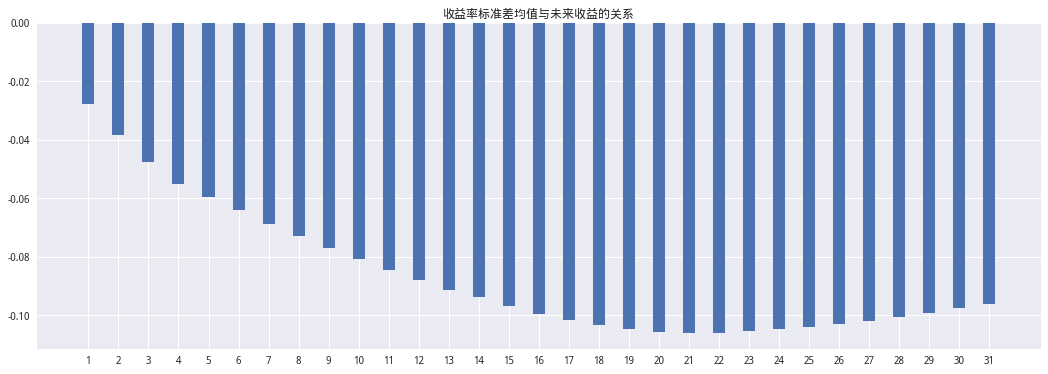

In [4]:
show_corrocef(HS300,ret_mean,"收益率标准差均值与未来收益的关系")

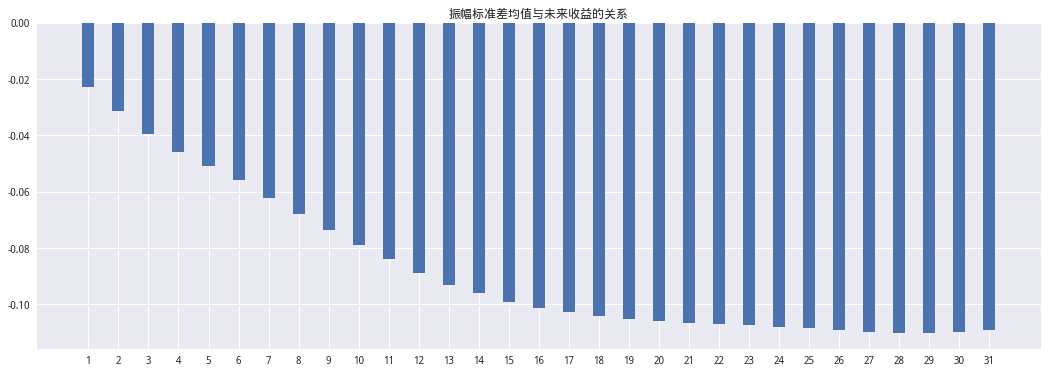

In [5]:
show_corrocef(HS300,amplitude_std,"振幅标准差均值与未来收益的关系")

## granger因果检验

>[是前因还是后果?——进行格兰杰因果检验](https://zhuanlan.zhihu.com/p/79936875)

>[statsmodels.tsa.stattools.grangercausalitytests](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html)

收益率标准差均值与收益率进行granger因果检验发现p值均大于显著性水平0.05,无法拒绝原假设收益率标准差均值无法对收益率进行较好的预测。

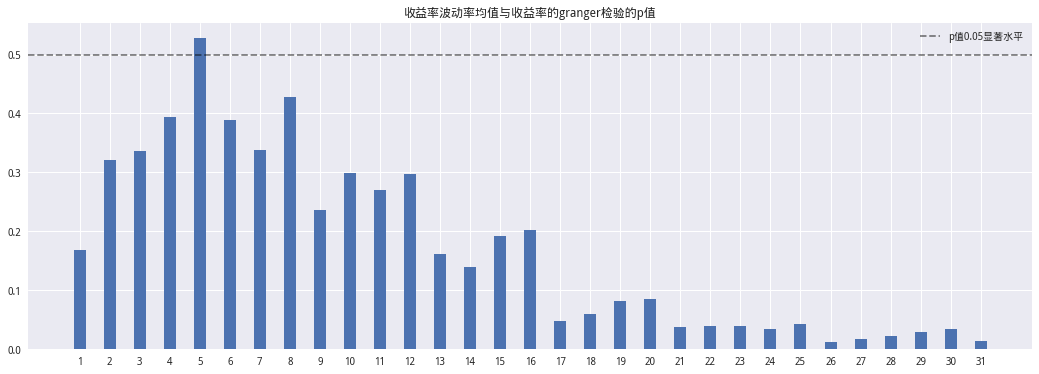

In [6]:
grangercausalitytests_pvalue(ret,ret_mean,'收益率波动率均值与收益率的granger检验的p值')

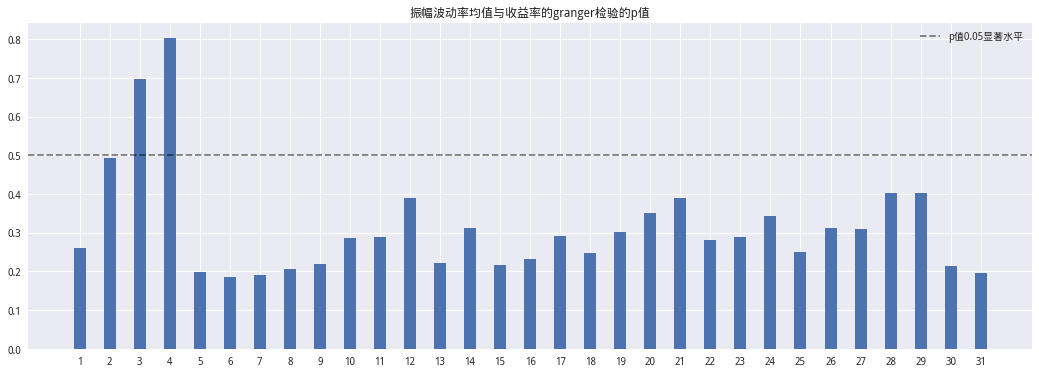

In [7]:
grangercausalitytests_pvalue(ret,amplitude_mean,'振幅波动率均值与收益率的granger检验的p值')

对于按其振幅来计算波动率是以开盘价为基准，开盘价以 上的波动定义为上行波动率，反之为下行波动率。而以标准计算是上涨日为
上行波动率，市场下跌时记为上行波动率为零值，下跌时则反之。

# 波动率分解：上行波动与下行波动

>由于A股市场做空机制相对欠缺，波动率分布并不对称。故有必要加以区分，我们把波动率区分为上行波动率与下行波动率。因此我们对上面的测试数据加以折分。对于按其振幅来计算波动率是以开盘价为基准，开盘价以上的波动定义为上行波动率，反之为下行波动率。而以标准计算是上涨日为上行波动率，市场下跌时记为上行波动率为零值，下跌时则反之。通常情况下市场处于上涨阶段时上行波动率要大于下行波动率，下跌阶段则反之，同时二者的差值我们定义为波动率剪刀差。


**振幅剪刀差**具体定义为：

上行波动 = (HIGH - OPEN)/OPEN 

下行波动 = (OPEN - LOW)/OPEN

剪刀差 = 上行波动 - 下行波动

**收益率剪刀差**具体定义为:

上行波动率 = np.where(ret > 0 ,std ,0)

下行波动率 = np.where(ret < 0 ,std ,0)

剪刀差 = 上行波动 - 下行波动

In [8]:
# 振幅剪刀差
Upward_volatility = HS300['high'] / HS300['open'] - 1
Downside_volatility = 1-HS300['low'] / HS300['open']

diff_vol = Upward_volatility - Downside_volatility

查看数据分布

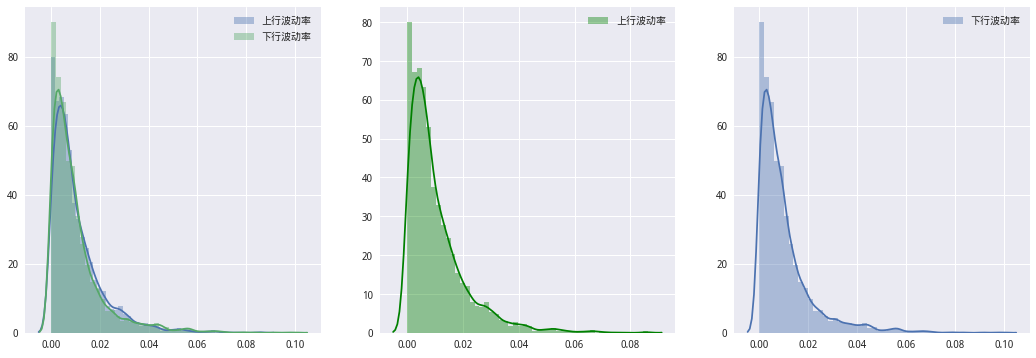

In [9]:
fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(1,3,1)
ax1 = sns.distplot(Upward_volatility.dropna(),label='上行波动率')
ax1 = sns.distplot(Downside_volatility.dropna(),label='下行波动率')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
ax2 = sns.distplot(Upward_volatility.dropna(),color='g',label='上行波动率')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
ax3 = sns.distplot(Downside_volatility.dropna(),label='下行波动率')
plt.legend()

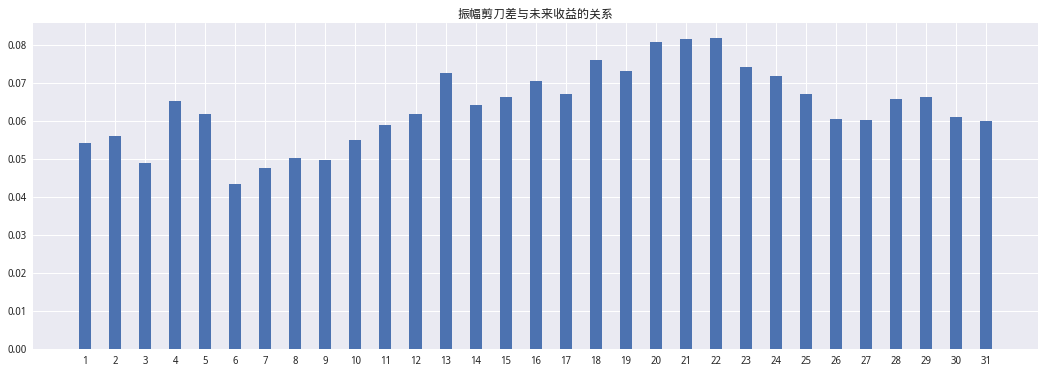

In [10]:
show_corrocef(HS300,diff_vol.loc[begin_date:watch_date],"振幅剪刀差与未来收益的关系")

In [11]:
# 振幅剪刀差
Upward_volatility = np.where(ret.loc[begin_date:watch_date] > 0 ,ret_std ,0)
Downside_volatility = np.where(ret.loc[begin_date:watch_date] < 0 ,ret_std ,0)

diff_vol = Upward_volatility - Downside_volatility

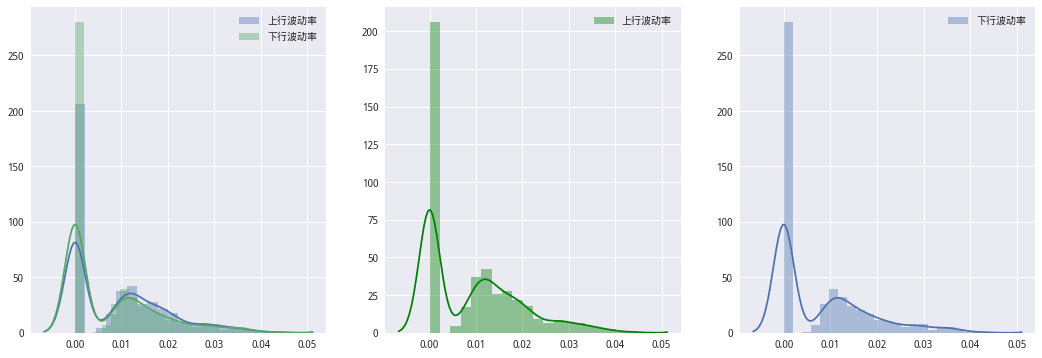

In [12]:
fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(1,3,1)
ax1 = sns.distplot(Upward_volatility,label='上行波动率')
ax1 = sns.distplot(Downside_volatility,label='下行波动率')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
ax2 = sns.distplot(Upward_volatility,color='g',label='上行波动率')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
ax3 = sns.distplot(Downside_volatility,label='下行波动率')
plt.legend()

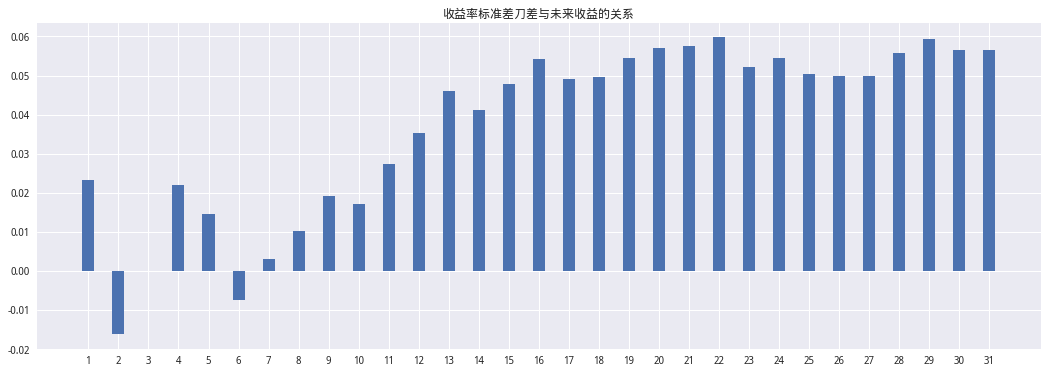

In [13]:
show_corrocef(HS300,pd.Series(diff_vol,ret_std.index),"收益率标准差刀差与未来收益的关系")

预测效果显示提升很多，无论是相关性绝对值与预测 N 日的稳定性都有明显的提高。其中按其振幅剪刀差计算波动率效果为最佳。**在下文中所提的波动率均是按其振幅来计算波动率。**

# 基于单向波动差构建择时策略

因此我们可以基于上面这个逻辑构建针对指数的择时策略，当前一天的上行波动率减去下行波动率的差值趋势（为增加稳定性，采用60日移动均值）**为正时就看多，反之则看空**。 回测区间为2006年至2016年看下图净值感觉还不错，中间回撤的幅度也有点大，超额收益也主要是来自 08 年。其它年份获取超额收益较少。(granger检验与研报不同 但简单回测结果确差不多...)

In [7]:
# 振幅剪刀差
Upward_volatility = HS300['high'] / HS300['open'] - 1
Downside_volatility = 1-HS300['low'] / HS300['open']

diff_vol = Upward_volatility - Downside_volatility

diff_ma = diff_vol.rolling(60).mean()

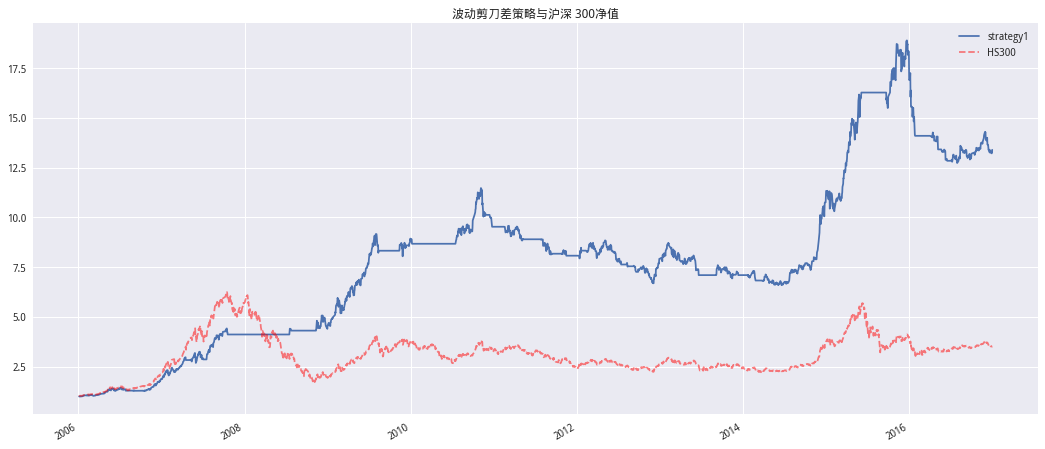

In [9]:
'''
strategy 1:
单向波动差移动平均为正：买入
单向波动差移动平均为负：卖出
'''

flag = np.where(diff_ma.loc[begin_date:watch_date] > 0, 1, 0)
slice_ser = ret.shift(-1).loc[begin_date:watch_date]
slice_benchmark = HS300.loc[begin_date:watch_date, 'close']

strategy_ret = flag * slice_ser
strategy_cum = (1 + strategy_ret).cumprod()
benchmark = slice_benchmark / slice_benchmark[0]

mpl.rcParams['font.family'] = 'serif'
plt.figure(figsize=(18, 8))
plt.title('波动剪刀差策略与沪深 300净值')
strategy_cum.plot()
benchmark.plot(color='r', ls='--', alpha=0.5)
legend(['strategy1', 'HS300'])


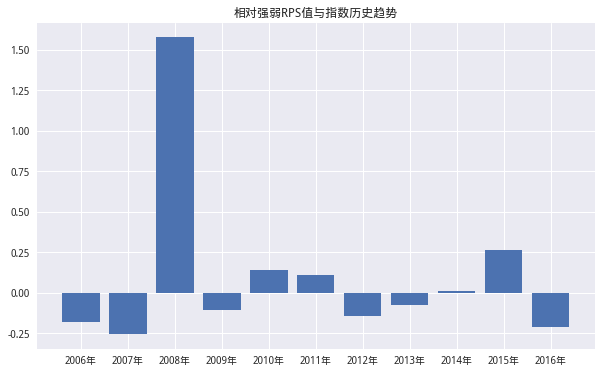

In [10]:
excess_ret = strategy_ret - ret.loc[begin_date:watch_date]
excess_cum = (1 + excess_ret).cumprod()

show_excess = excess_cum.groupby(
    pd.Grouper(freq='Y')).apply(lambda x: pow(x[-1] / x[0], 244 / len(x)) - 1)

plt.figure(figsize=(10,6))
plt.title('相对强弱RPS值与指数历史趋势')

plt.bar(range(len(show_excess)),show_excess.values)
plt.xticks(range(len(show_excess)),['%s年'%x.strftime('%Y') for x in show_excess.index])
plt.show()

研报认为
>预测值在强势市场中对当天波动率不是很敏感，在市场调整、震荡区间 中对波动率要相对敏感一些。因此，单向波动差值策略还需要接合市场特征指标加以完善。

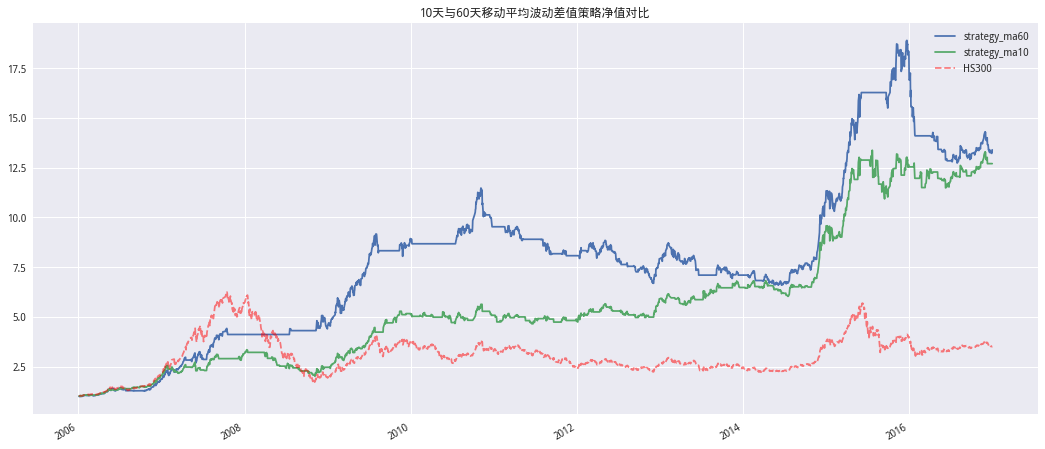

In [11]:
'''
strategy 1:
单向波动差移动平均为正：买入
单向波动差移动平均为负：卖出
'''

diff_ma10 = diff_vol.rolling(10).mean()

flag_1 = np.where(diff_ma10.loc[begin_date:watch_date] > 0, 1, 0)
slice_ser = ret.shift(-1).loc[begin_date:watch_date]

strategy_ret1 = flag_1 * slice_ser
strategy_cum1 = (1 + strategy_ret1).cumprod()

plt.figure(figsize=(18, 8))
plt.title('10天与60天移动平均波动差值策略净值对比')
strategy_cum.plot()
strategy_cum1.plot()
benchmark.plot(color='r', ls='--', alpha=0.5)
legend(['strategy_ma60','strategy_ma10', 'HS300'])


# 相对强弱 RPS指标

"强者恒强、弱者恒弱"常为市场所证实。个股或市场的强弱表现其本身就 是基本面、资金面、投资者情绪等多种因素的综合作用下的体现。通常市场 强势与否，可以用市场相对强弱 RPS 指标来表示。 

1. 计算 RPS 值 RPS_1=(当前涨跌幅-MIN(250 交易日涨幅))/(MAX(250 交易日涨幅)-MIN(250 交易日涨幅)) （注：其值在 0%到 100%区间内）
2. 然后取 10 个交易日移动平均值：RPS=MA(RPS_1)

<font color=DarkRed>**根据尝试发现RPS的定义应该是**:</font>

RPS_1 = (当前收盘价 - min(过去250日收盘价))/(max(过去250日收盘价）-min(过去250日收盘价))

RPS = RPS_1的10日移动平均值

不是用涨跌幅....坑爹啊！

In [73]:
# 计算RPS
def GetRPS(df: pd.DataFrame,period:int)->pd.Series:

    rps = (df['close'] - df['close'].rolling(250,min_periods=0).min()) / (
        df['close'].rolling(250,min_periods=0).max() - df['close'].rolling(250,min_periods=0).min())

    return rps.rolling(period,min_periods = 0).mean().loc[begin_date:watch_date]

跟报告对比貌似就是用收盘价

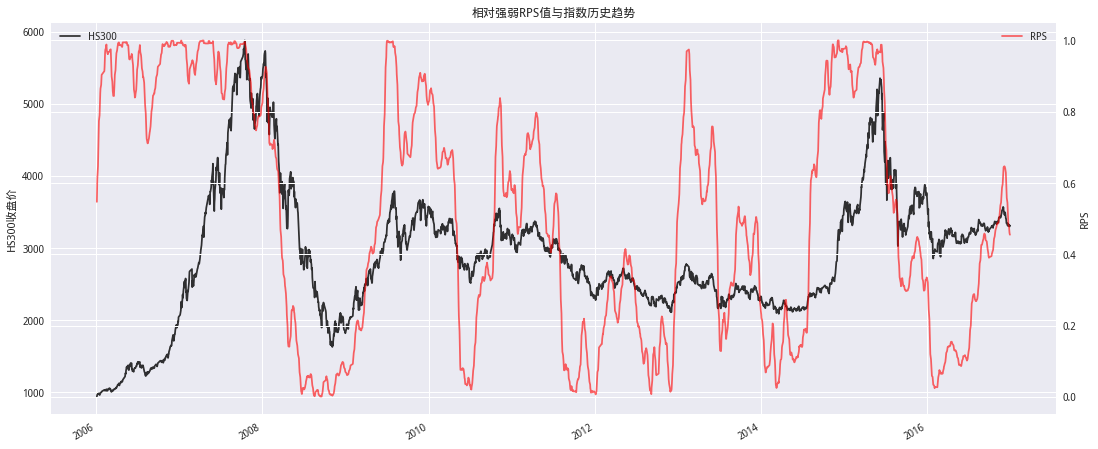

In [71]:
# 计算rps
rps = GetRPS(HS300,10).dropna()

plt.figure(figsize=(18,8))
plt.title('相对强弱RPS值与指数历史趋势')
slice_benchmark.plot(color='black',alpha=0.8)
plt.ylabel('HS300收盘价')
plt.legend(['HS300'],loc=2)

plt.twinx()
rps.plot(color='r',alpha=0.6)
plt.ylabel('RPS')
plt.legend(['RPS'],loc=1)

从图也能看出，RPS能很好的刻画出市场的状态，市场强势时，RPS高位，市场震荡时，RPS低位。因此可以用RPS来指导单向波动差的窗宽，RPS高位时，窗宽较大，RPS低位时，窗宽较小。

择时策略2

在使用RPS指导单向波动差的窗宽设定之前，报告用RPS做了一个简单回测确保这个逻辑时合理的，如下标记部分。

>可以看出RPS值能较好的表达市场是否处于强势。基于这个思想，可以在RPS值在高位时计算当天的移动波动率差值就用较长天数的，当 RPS 值在低位时就用相对较短天数的波动率差移动均值。 市场相对强弱 RPS 值较高时保持高仓位才是最好的选择。我们来测试一 下基于这个逻辑的策略是否符合以上所说。 测试方法说明：当 RPS 值在 80%以上时，说明其趋势保持相当好，这方面研究结论很多，例如欧奈尔的CNASLIM策略只选 RPS 值在 80%的上个股。故在 这个区域是相对较为安全的区间。在这区间内持有是最佳选择。（<u>***当前一个交易日 RPS 值上穿 80%安全边界线时买入，下穿 80%安全边界线卖出***</u>）

结果基本一致...

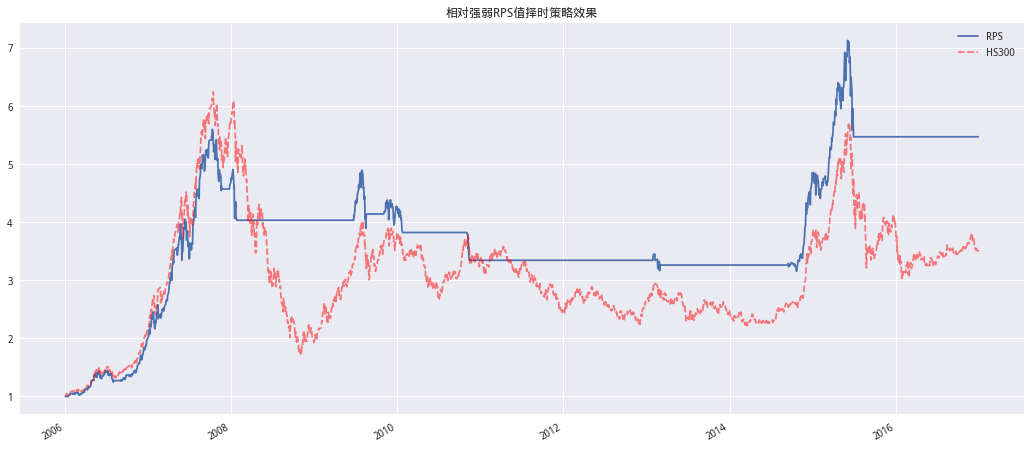

In [72]:
"""
strategy 2
RPS上穿80%，买入
RPS下穿80%，卖出
"""

pre_rps = rps.shift(1)

flag = []
for trade_date,rps_values in rps.items():
    
    last = rps_values
    per = pre_rps.loc[trade_date]
    
    if (last > 0.8) and (per < 0.8):
        
        flag.append(1)
    
    elif (last < 0.8) and (per >0.8):
        
        flag.append(0)
        
    else:
        try:
            last_flag = flag[-1]
        except IndexError:
            last_flag = 0
            
        flag.append(last_flag)
        
strategy2_ret = flag * slice_ser.shift(-1).loc[rps.index]
strategy2_cum = (1 + strategy2_ret).cumprod()

plt.figure(figsize=(18, 8))
plt.title('相对强弱RPS值择时策略效果')
strategy2_cum.plot()
benchmark.loc[strategy2_cum.index].plot(color='r', ls='--', alpha=0.5)
legend(['RPS', 'HS300'])

# 相对强弱 RPS下波动率差值策略

>策略步骤简介: 
1. 计算相应指数相对强弱RPS 
2. 计算相应指数上行波动率、下行波动率，并计算二者差值 
3. 计算当天波动率差值的移动均值天数由 RPS 值确定、RPS 值越大相就取的天数越多
4. 观察前一天的(波动率差值的移动均值)，如为正就保持持有（或卖入）、否则就保持空仓（或卖出）。

报告中并没有给出具体的RPS值跟移动平均窗宽之间的关系，所以就只能自己尝试了，这里我尝试了一个很简单的逻辑：RPS的值都在0-1之间，设定最大窗宽为60，最小为1，根据RPS对窗宽做一个线性的插值，再取整。最终回测结果如下:

In [108]:
def Sensitivity_analysis(close_df: pd.DataFrame, period: int):

    rps = GetRPS(close_df, period).dropna()
    ret = close_df['close'] / close_df['pre_close'] - 1
    
    up = np.where(ret.loc[rps.index] > 0,rps,0)
    down = np.where(ret.loc[rps.index] <= 0,rps,0)
    
    diff_ = pd.Series(up - down,rps.index)
    diff_ = diff_.rolling(period,min_periods=0).mean()
    
    flag = np.where(diff_ > 0, 1, 0)

    strategy_ret = flag * ret.shift(-1).loc[rps.index]
    strategy_cum = (1 + strategy_ret).cumprod()

    Total_Annualized_Returns = pow(strategy_cum[-2] / strategy_cum[0],
                                   250 / len(strategy_cum)) - 1
                                   
    return strategy_cum,Total_Annualized_Returns

In [112]:
period = np.arange(1,61,1)
temp = {}
for i in tqdm(period,desc='寻找参数'):
    _,Total_Annualized_Returns = Sensitivity_analysis(HS300,i)
    temp[i] = Total_Annualized_Returns

寻找参数: 100%|██████████| 60/60 [00:00<00:00, 87.30it/s]


In [118]:
print('收益最优的移动平均参数为:%s'%max(temp,key=temp.get))

收益最优的移动平均参数为:13


结果相比于之前回撤降低了很多，但远远达不到报告中的逆天效果，而且我这里还是没有考虑交易成本的。

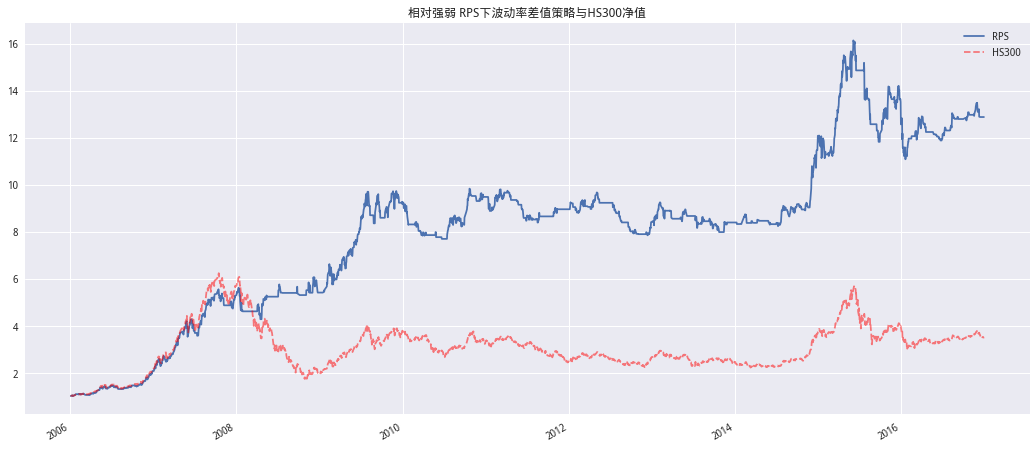

In [119]:
strategy_cum,Total_Annualized_Returns = Sensitivity_analysis(HS300,13)

plt.figure(figsize=(18, 8))
plt.title('相对强弱 RPS下波动率差值策略与HS300净值')
strategy_cum.plot()
benchmark.loc[strategy_cum.index].plot(color='r', ls='--', alpha=0.5)
legend(['RPS', 'HS300'])

**RPS分级靠档**

报告后续测试指出，前文给出的通过RPS确定窗宽的方法太灵敏，RPS的微小变动会引起窗宽的迅速调整，因此可以对RPS的值进行分级靠档，以降低交易频率，具体来说:

|RPS|移动天数|
|--|--|
|0%到20%|20|
|20%到40%|40|
|40%到60%|60|
|60%到80%|80|
|80%到100%|100|

可能由于前序没能完美复现 所以后面的效果不太好....